# Twitter Analysis - University comparison

This notebook works with the data extracted from the main twitter databse in the RCC. 

It explores the possible trends we can observe and whether any actionable insights can be recommended.

------------

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
from IPython.core.display import display, HTML
import pandas as pd
%reload_ext autoreload
%autoreload 1
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth',100)    

display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from itertools import combinations, takewhile
import collections
import pandas as pd
import numpy as np
import os

from simhash import Simhash, SimhashIndex

sns.set()

from Utils.UtilsViz import *
# from Utils.UtilsGeoViz import *

KeyboardInterrupt: 

In [2]:
os.getcwd()

'D:\\Dev\\Sources\\Projects\\GitProjects\\BigDataEngg\\final_project'

In [3]:
fpath = os.path.join(os.getcwd(), "all_uni_data.csv")
tweets_df = pd.read_csv(fpath, index_col="Unnamed: 0")#, nrows=1e6)
display(
    tweets_df.shape,
    tweets_df.head()
)

(3070129, 23)

,coordinates,created_at,entities_hashtags,favorite_count,favorited,id_str,in_reply_to_status_id_str,in_reply_to_user_id_str,place_country,place_country_code,place_name,place_type,retweet_count,retweeted,retweeted_status_user_id_str,retweeted_status_user_name,text,user_favorites_count,user_followers_count,user_friends_count,user_id_str,user_name,user_statuses_count
0,NaN,2017-06-22 23:16:53,[],0.0,False,8.780290e+17,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False,3.366467e+08,John McGonigal,RT @jmcgonigal9: Penn State student section tickets sold out in 89 minutes\r\n\r\nhttps://t.co/K...,132.0,3.0,44.0,7.740459e+17,David Kononchuk,130.0
1,NaN,2017-06-22 23:17:13,"[{'indices': [112, 115], 'text': 'Wx'}]",0.0,False,8.780291e+17,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False,NaN,NaN,...A SIGNIFICANT WEATHER ADVISORY HAS BEEN ISSUED UNTIL 630 PM CDT FOR... Northwestern Marshall ...,0.0,602.0,607.0,8.881816e+08,AmericaAlerts App,85724.0
2,NaN,2017-06-22 23:17:47,[],0.0,False,8.780293e+17,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False,NaN,NaN,Inspired by this innovative wave 4 forming whole students that @CSUDH is riding &amp; stoking w/...,693.0,875.0,1221.0,2.363593e+09,Giacomo,3086.0
3,NaN,2017-06-22 23:17:53,[],0.0,False,8.780293e+17,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False,7.091099e+17,David Eccles,RT @gringene_bio: @Big3BioSF @OmicsOmicsBlog @Stanford @PacBio If you're making DNA look like it...,5796.0,1047.0,1054.0,1.204189e+08,Samuel Lampa,9391.0
4,NaN,2017-06-22 23:17:56,[],0.0,False,8.780293e+17,8.780287e+17,1.244408e+09,NaN,NaN,NaN,NaN,0.0,False,NaN,NaN,@SheWhoVotes He went to Northwestern Law School? ðŸ˜‚ jk ðŸ—¿,1189.0,85.0,107.0,7.011908e+17,Janna Propaganda,3328.0


## Clean up the hashtags

In [4]:
def clean_hashtags(row):
    try:
        if row == "[]":
            return []
        if row is None:
            return []
        if row is np.NaN:
            return []
        if (len(row) == 0):
            return []
        tags = []
    #     for item in row:
    #         tags.append(item.text)
        s = row.replace("\'", "\"")
        d = json.loads(s)
        for item in d:
            tags.append(item["text"])
        return tags
    except Exception as e:
#         print("Exception caught : ", e, "for row\n\t", row)
        return []
    
    
tweets_df["hashtags_cleaned"] = tweets_df["entities_hashtags"].apply(clean_hashtags)

In [5]:
tweets_df["text"].fillna(value="", inplace=True)
tweets_df["text_len"] = tweets_df["text"].apply(len)

-----------

# Identify tweets related to UChicago and a few other universities 

In [59]:
uc_favored_tags = ["uchicago", "uchearing", "universityofchicago", "pritzkerschoolofmedicine",
                   "uofc", "maroonmade", "chicagobooth"]
nw_favored_tags = ["northwestern"]
upenn_favored_tags = ["upenn", "penn", "uofpenn", "universityofpennsylvania", "pennlaw", "upennhearing"]
uic_favored_tags = ["UIC", "UICProud"]
# mit_favored_tags = ["MIT"]
stanford_favored_tags = ["stanford"]

def is_stanford_tweet(row):
    if row is np.NaN:
        return False
    for ftag in stanford_favored_tags:
        for tag in row:
            if ftag.lower() in tag.lower():
                return True
    return False

def is_upenn_tweet(row):
    if row is np.NaN:
        return False
    for ftag in upenn_favored_tags:
        for tag in row:
            if ftag.lower() in tag.lower():
                return True
    return False

def is_nw_tweet(row):
    if row is np.NaN:
        return False
    for ftag in nw_favored_tags:
        for tag in row:
            if ftag.lower() in tag.lower():
                return True
    return False

def is_uc_tweet(row):
    if row is np.NaN:
        return False
    for ftag in uc_favored_tags:
        for tag in row:
            if ftag.lower() in tag.lower():
                return True
    return False

def is_uic_tweet(row):
    if row is np.NaN:
        return False
    for ftag in uic_favored_tags:
        for tag in row:
            if ftag.lower() in tag.lower():
                return True
    return False

# def is_mit_tweet(row):
#     if row is np.NaN:
#         return False
#     for ftag in mit_favored_tags:
#         for tag in row:
#             if ftag.lower() == tag.lower():
#                 return True
#     return False

# tweets_df["mit_tweet"] = tweets_df["hashtags_cleaned"].apply(is_mit_tweet)
tweets_df["stanford_tweet"] = tweets_df["hashtags_cleaned"].apply(is_stanford_tweet)
tweets_df["nw_tweet"] = tweets_df["hashtags_cleaned"].apply(is_nw_tweet)
tweets_df["upenn_tweet"] = tweets_df["hashtags_cleaned"].apply(is_upenn_tweet)
tweets_df["uc_tweet"] = tweets_df["hashtags_cleaned"].apply(is_uc_tweet)
tweets_df["uic_tweet"] = tweets_df["hashtags_cleaned"].apply(is_uic_tweet)

cols = ["uc_tweet", 
        "uic_tweet", 
#         "mit_tweet", 
        "stanford_tweet", 
        "upenn_tweet", 
        "nw_tweet"]

def is_uni_tweet(row):
    for col in cols:
        if row[col]:
            return True
    else:
        return False

tweets_df["uni_tweet"] = tweets_df[cols].apply(is_uni_tweet, axis=1)

def is_uni_tweet2(row):
    for col in cols:
        if row[col]:
            return col[0:-6]
    else:
        return ""

tweets_df["uni_tweet_name"] = tweets_df[cols].apply(is_uni_tweet2, axis=1)

# tweets_df[["uc_tweet", "uic_tweet", "stanford_tweet", "upenn_tweet", "nw_tweet", "uni_tweet"]]
display(
    tweets_df["uc_tweet"].value_counts(),
    tweets_df["uic_tweet"].value_counts(),
    tweets_df["stanford_tweet"].value_counts(),
    tweets_df["upenn_tweet"].value_counts(),
    tweets_df["nw_tweet"].value_counts(),
    tweets_df["uni_tweet"].value_counts()
)

False    3050197
True       19932
Name: uc_tweet, dtype: int64

False    3048731
True       21398
Name: uic_tweet, dtype: int64

False    2983438
True       86691
Name: stanford_tweet, dtype: int64

False    3055754
True       14375
Name: upenn_tweet, dtype: int64

False    3010742
True       59387
Name: nw_tweet, dtype: int64

False    2869696
True      200433
Name: uni_tweet, dtype: int64

Make a subset data set that only picks tweets related to universities we're analysing.

In [60]:
uni_df = tweets_df[(tweets_df["uni_tweet"]==True)]

Let's just quickly make a Time dimension for ease of use later on.

In [61]:
uni_df["created_at"] = pd.to_datetime(uni_df['created_at'])

In [62]:
uni_df['created_month'] = uni_df['created_at'].map(lambda x: x.month)
uni_df['created_year'] = uni_df['created_at'].map(lambda x: x.year)
uni_df['created_date'] = uni_df['created_at'].map(lambda x: x.day)
uni_df['created_dayofweek'] = uni_df['created_at'].map(lambda x: x.weekday_name)

In [63]:
uni_df.shape

(200433, 36)

------------

# Identify the most prolific / influential Twitterers
1. By message volume
1. By message retweet
1. How much are they tweeting about the Universities vs. other topics? 

Can we identify Retweets?

In [64]:
uni_df["retweeted_status_user_id_str"].count()

90640

## Most active users

In [65]:
user_grp = uni_df[["id_str", "user_id_str", "user_name"]].groupby(by=["user_name"], as_index=False).count()
user_grp.reset_index(drop=True, inplace=True)
user_grp.sort_values(by="id_str", inplace=True, ascending=False)
user_grp.head()

,user_name,id_str,user_id_str
48365,Northwestern Spyder,4678,4678
60026,Stanford SportSpyder,3336,3336
46607,NUMBSpiritLeader,2819,2819
72291,hamilton,1502,1502
65827,UChicago,965,965


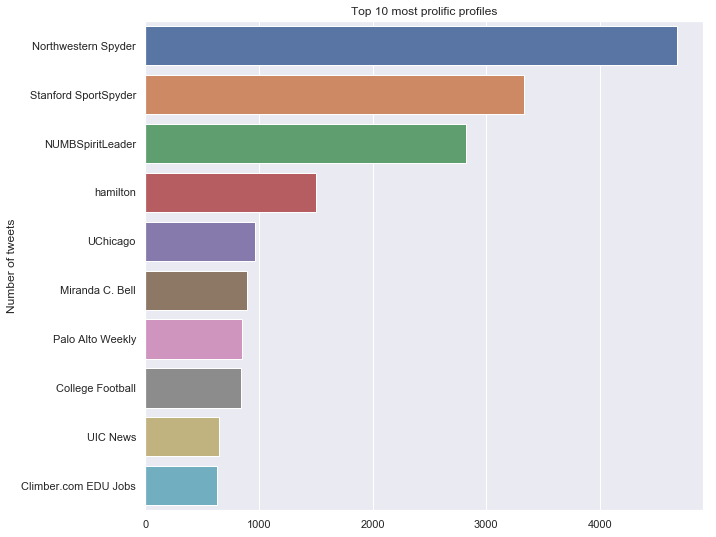

In [93]:
user_subset = user_grp.iloc[:10,:]
user_subset.reset_index(drop=True, inplace=True)
f, ax = plt.subplots(1, 1, figsize=(10,9))
# plot_bar(data=user_subset, x="user_name", y="id_str", ax=ax, title="Message volume of top 10 users", highlight_max_min=False, annot=False)
g = sns.barplot(data=user_subset, y="user_name", x="id_str", ax=ax)
t = g.set(ylabel="Number of tweets", title="Top 10 most prolific profiles", xlabel="")

### How much are they tweeting about the Universities vs. other topics?

In [67]:
user_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
user_name      10 non-null object
id_str         10 non-null int64
user_id_str    10 non-null int64
dtypes: int64(2), object(1)
memory usage: 320.0+ bytes


In [68]:
prolific_users = user_subset["user_name"].unique()

In [69]:
cols = ["id_str", "user_id_str", "text", "user_name", "hashtags_cleaned", "uc_tweet", "uic_tweet", "stanford_tweet", "upenn_tweet", "nw_tweet", "uni_tweet"] # "mit_tweet", 
uvnu_df = tweets_df[tweets_df["user_name"].isin(prolific_users)][cols]
def tmpfun(row):
    if row:
        return 1
    else:
        return 0
uvnu_df["uni_tweet"] = uvnu_df["uni_tweet"].apply(tmpfun)
uvnu_df.shape

(18672, 11)

In [70]:
tmp_df = uvnu_df[["user_name", "uni_tweet"]].groupby(by="user_name", as_index=False).agg(["sum", "count"])
tmp_df.columns = ["uni_tweets", "total_tweets"]
tmp_df.reset_index(drop=False, inplace=True)
tmp_df["ratio"] = tmp_df["uni_tweets"] / tmp_df["total_tweets"]
tmp_df

,user_name,uni_tweets,total_tweets,ratio
0,Climber.com EDU Jobs,633,635,0.996850
1,College Football,837,1263,0.662708
2,Miranda C. Bell,897,910,0.985714
3,NUMBSpiritLeader,2819,2819,1.000000
4,Northwestern Spyder,4678,4692,0.997016
5,Palo Alto Weekly,850,888,0.957207
6,Stanford SportSpyder,3336,3350,0.995821
7,UChicago,965,1761,0.547984
8,UIC News,650,792,0.820707
9,hamilton,1502,1562,0.961588


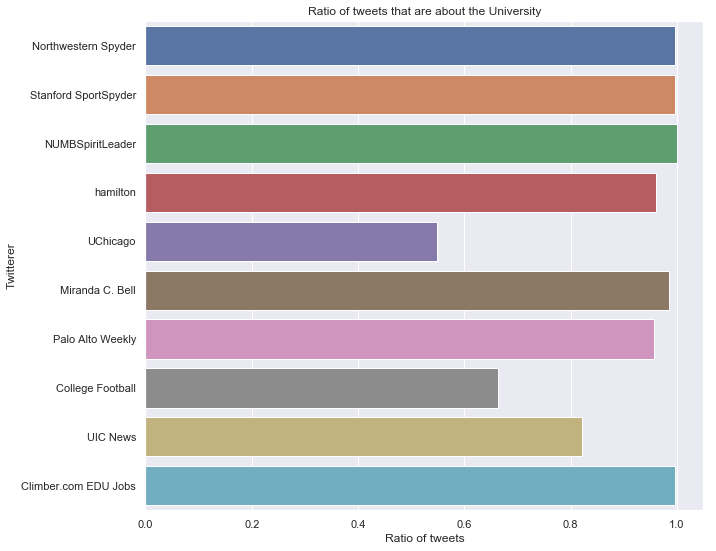

In [94]:
f, ax = plt.subplots(1,1,figsize=(10,9))
# plot_bar(data=tmp_df, x="user_name", y="ratio", ax=ax, highlight_max_min=False, annot=False)
g = sns.barplot(data=tmp_df, y="user_name", x="ratio", ax=ax, order=['Northwestern Spyder','Stanford SportSpyder','NUMBSpiritLeader','hamilton','UChicago','Miranda C. Bell','Palo Alto Weekly', 'College Football', 'UIC News', 'Climber.com EDU Jobs' ])
t = g.set(xlabel="Ratio of tweets", title="Ratio of tweets that are about the University", ylabel="Twitterer")

### Message Retweet

Which users had most of their work retweeted?

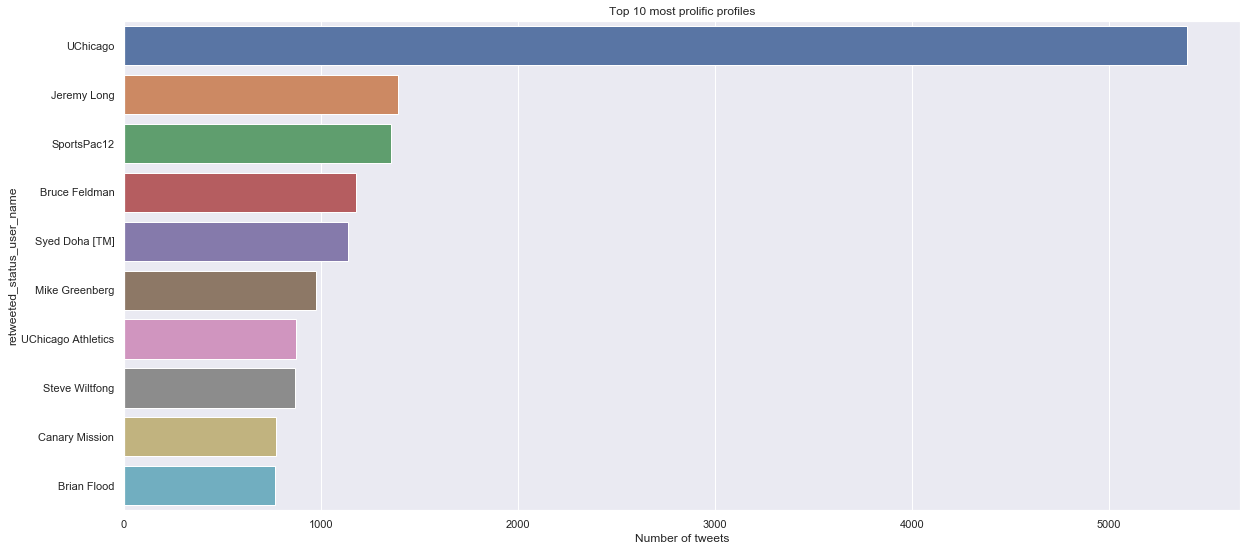

In [73]:
user_rt_grp = uni_df[["id_str", "retweeted_status_user_name"]].groupby(by=["retweeted_status_user_name"], as_index=False).count()
user_rt_grp.reset_index(drop=True, inplace=True)
user_rt_grp.sort_values(by="id_str", inplace=True, ascending=False)

user_subset = user_rt_grp.iloc[:10,:]
user_subset.reset_index(drop=True, inplace=True)
f, ax = plt.subplots(1, 1, figsize=(20,9))
# plot_bar(data=user_subset, x="retweeted_status_user_name", y="id_str", ax=ax, title="Retweet volume of top 10 twitterers", highlight_max_min=False, annot=False)
g = sns.barplot(data=user_subset, y="retweeted_status_user_name", x="id_str", ax=ax)
t = g.set(title="Top 10 most prolific profiles", xlabel="Number of tweets")

## Where are these Twitterers located?
-  For UChicago
-  For other universities
-  Do you see any relationship between university locations and Twitterers’ locations?
-  Visualize the relationships

In [74]:
places_df = uni_df[["id_str", "user_name", "place_country", "place_country_code", "place_name", "place_type", "uni_tweet_name"]].dropna()
places_df.head()

,id_str,user_name,place_country,place_country_code,place_name,place_type,uni_tweet_name
856,8.989279e+17,TMJ-KYL Sales Jobs,United States,US,Stanford,city,stanford
860,8.989286e+17,Guckenheimer Careers,United States,US,Stanford,city,stanford
892,8.989315e+17,Guckenheimer Careers,United States,US,Stanford,city,stanford
918,8.989350e+17,HumMigraineResearchU,United States,US,Iris & B. Gerald Cantor Center for Visual Arts,poi,stanford
946,8.989386e+17,Graham McComiskie,United States,US,Philadelphia,city,upenn


In [75]:
def get_top5_places(dfs):
    return dfs.value_counts().iloc[:5].index

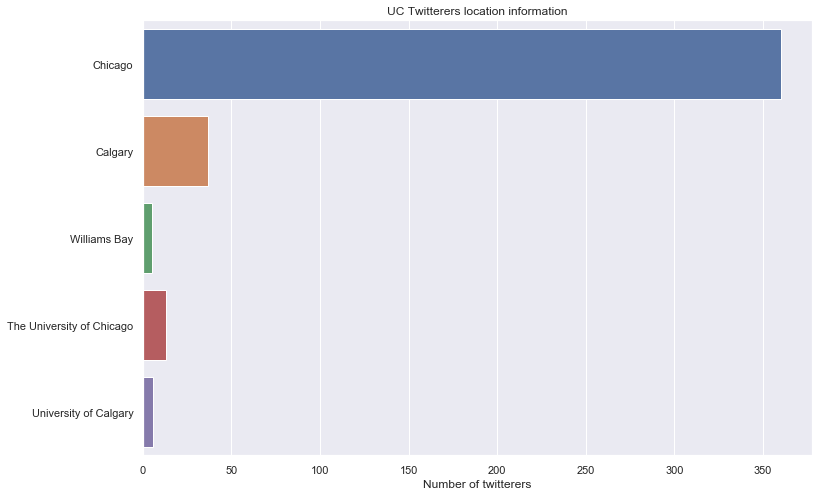

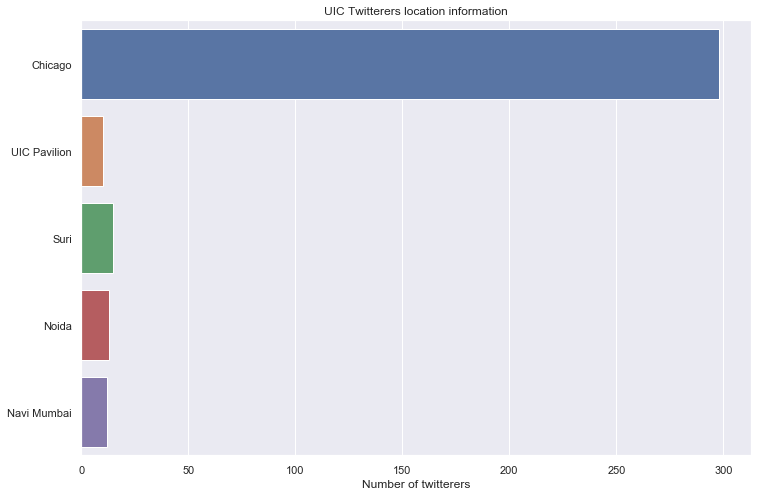

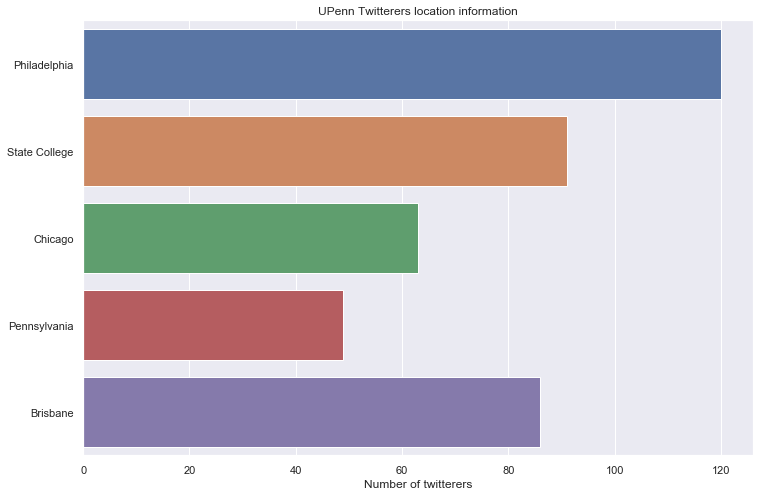

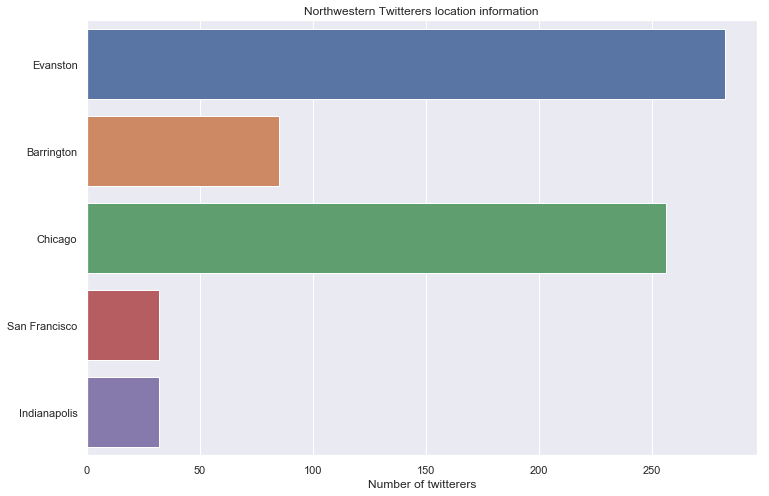

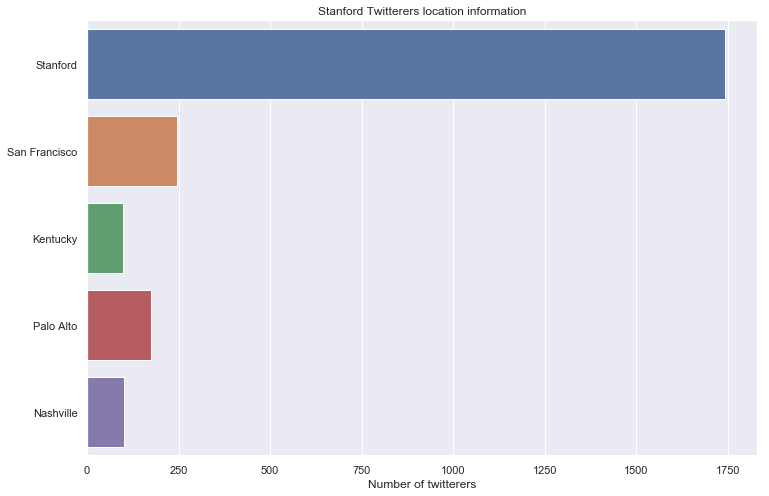

In [76]:
uc_places_df = places_df[places_df["uni_tweet_name"]=="uc"]
upenn_places_df = places_df[places_df["uni_tweet_name"]=="upenn"]
uic_places_df = places_df[places_df["uni_tweet_name"]=="uic"]
nw_places_df = places_df[places_df["uni_tweet_name"]=="nw"]
stanford_places_df = places_df[places_df["uni_tweet_name"]=="stanford"]
# mit_places_df = places_df[places_df["uni_tweet_name"]=="mit"]

# Just use the top 5 places
uc_places_df = uc_places_df[uc_places_df["place_name"].isin(get_top5_places(uc_places_df["place_name"]))]
upenn_places_df = upenn_places_df[upenn_places_df["place_name"].isin(get_top5_places(upenn_places_df["place_name"]))]
uic_places_df = uic_places_df[uic_places_df["place_name"].isin(get_top5_places(uic_places_df["place_name"]))]
nw_places_df = nw_places_df[nw_places_df["place_name"].isin(get_top5_places(nw_places_df["place_name"]))]
stanford_places_df = stanford_places_df[stanford_places_df["place_name"].isin(get_top5_places(stanford_places_df["place_name"]))]
# mit_places_df = mit_places_df[mit_places_df["place_name"].isin(get_top5_places(mit_places_df["place_name"]))]

f, ax = plt.subplots(1, 1,figsize=(12, 8))
g = sns.countplot(y="place_name", data=uc_places_df, ax=ax)
t = ax.set(title="UC Twitterers location information", xlabel="Number of twitterers", ylabel="")
# t = g.set_xticklabels(g.get_xticklabels(), rotation=0)

f, ax = plt.subplots(1, 1,figsize=(12, 8))
g = sns.countplot(y="place_name", data=uic_places_df, ax=ax)
t = ax.set(title="UIC Twitterers location information", xlabel="Number of twitterers", ylabel="")

f, ax = plt.subplots(1, 1,figsize=(12, 8))
g = sns.countplot(y="place_name", data=upenn_places_df, ax=ax)
t = ax.set(title="UPenn Twitterers location information", xlabel="Number of twitterers", ylabel="")

f, ax = plt.subplots(1, 1,figsize=(12, 8))
g = sns.countplot(y="place_name", data=nw_places_df, ax=ax)
t = ax.set(title="Northwestern Twitterers location information", xlabel="Number of twitterers", ylabel="")

f, ax = plt.subplots(1, 1,figsize=(12, 8))
g = sns.countplot(y="place_name", data=stanford_places_df, ax=ax)
t = ax.set(title="Stanford Twitterers location information", xlabel="Number of twitterers", ylabel="")

# g = sns.countplot(x="place_name", data=mit_places_df, ax=ax[2][1])
# t = ax[2][1].set(title="MIT Twitterers location information", ylabel="Number of twitterers", xlabel="")
# ax[5].set_visible(False)
# st = plt.suptitle("Top 5 places of all twitterers")


# What distinguishes University of Chicago Twitterers vs other Twitterers
Visualize the trends

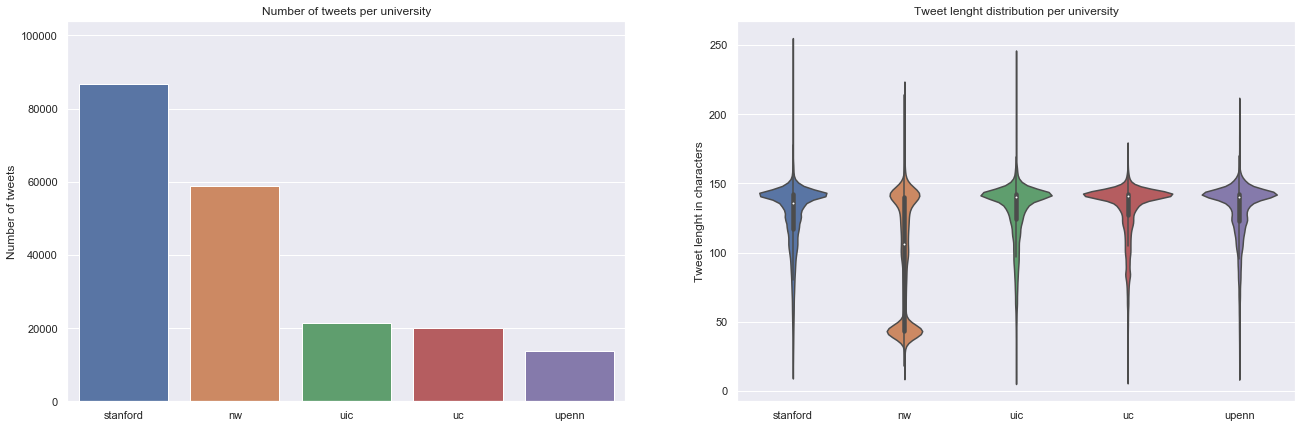

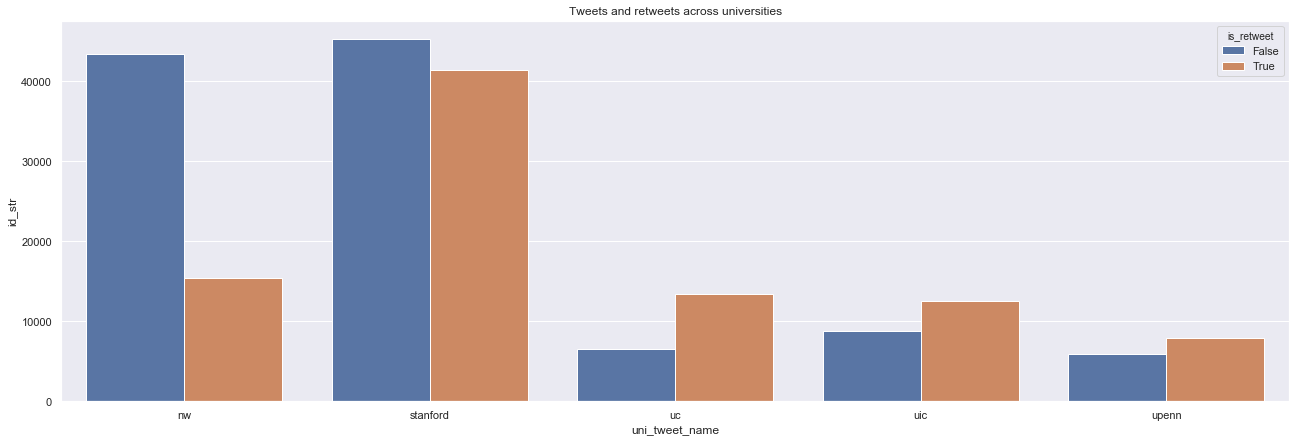

In [95]:
f, ax = plt.subplots(1,2,figsize=(22,7))

uni_counts = uni_df["uni_tweet_name"].value_counts().to_frame()
uni_counts.reset_index(drop=False, inplace=True)
uni_counts.columns = ["university", "num_tweets"]
plot_bar(x="university", y="num_tweets", data=uni_counts, ax=ax[0], highlight_max_min=False,
        title="Number of tweets per university", ylabel="Number of tweets", annot=False)

sns.violinplot(data=uni_df, x="uni_tweet_name", y="text_len", ax=ax[1], order=["stanford", "nw", "uic", "uc", "upenn"])
t = ax[1].set(title="Tweet lenght distribution per university", ylabel="Tweet lenght in characters", xlabel="")

rt_uni_df = uni_df[["id_str", "retweeted_status_user_id_str", "uni_tweet_name"]]
def is_retweet(row):
    if str(row).lower() == "nan":
        return False
    else:
        return True
# rt_uni_df["is_retweet"] = rt_uni_df["retweeted_status_user_id_str"].apply(lambda x: True if x is not np.NaN else False)
rt_uni_df["is_retweet"] = rt_uni_df["retweeted_status_user_id_str"].apply(is_retweet)

rt_uni_grp = rt_uni_df.groupby(["uni_tweet_name", "is_retweet"], as_index=False).count()

f, ax = plt.subplots(1, 1, figsize=(22, 7))
g = sns.barplot(x="uni_tweet_name", y="id_str", hue="is_retweet", data=rt_uni_grp, ax=ax)
t = g.set(title="Tweets and retweets across universities")

## Tweet frequency across time

Are there any clear trends on what days to people tweet the most often about the universities?

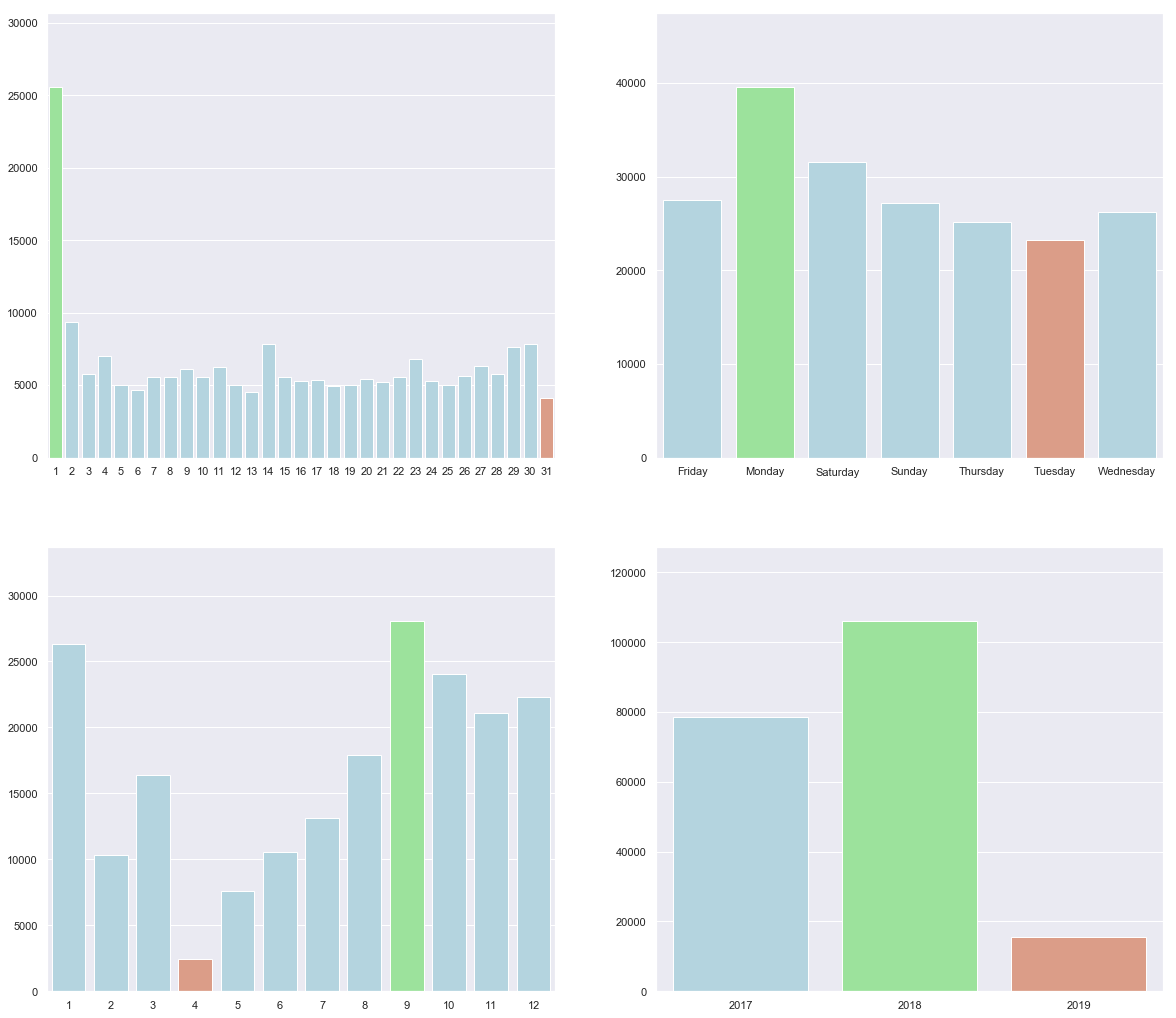

In [78]:
uni_df_date_grp = uni_df[["id_str", "created_date"]].groupby(by="created_date", as_index=False).count()
uni_df_dayofweek_grp = uni_df[["id_str", "created_dayofweek"]].groupby(by="created_dayofweek", as_index=False).count()
uni_df_month_grp = uni_df[["id_str", "created_month"]].groupby(by="created_month", as_index=False).count()
uni_df_year_grp = uni_df[["id_str", "created_year"]].groupby(by="created_year", as_index=False).count()

f, ax = plt.subplots(2,2,figsize=(20,18))
plot_bar(data=uni_df_date_grp, x="created_date", y="id_str", ax=ax[0][0], annot=False)
plot_bar(data=uni_df_dayofweek_grp, x="created_dayofweek", y="id_str", ax=ax[0][1], annot=False )
plot_bar(data=uni_df_month_grp, x="created_month", y="id_str", ax=ax[1][0], annot=False)
plot_bar(data=uni_df_year_grp, x="created_year", y="id_str", ax=ax[1][1], annot=False)

## How unique are the messages for each of these universities?
-  Are they mostly unique? Or mostly people are just copy-pasting the same text?
-  You can use something like Jaccard similarity / Cosine Similarity / Simhash / Minhash to measure uniqueness / similarity
-  Visualize message duplication (for each university – not between the universities)

In [79]:
tweets_df["text"].head()

0    RT @jmcgonigal9: Penn State student section tickets sold out in 89 minutes\r\n\r\nhttps://t.co/K...
1    ...A SIGNIFICANT WEATHER ADVISORY HAS BEEN ISSUED UNTIL 630 PM CDT FOR... Northwestern Marshall ...
2    Inspired by this innovative wave 4 forming whole students that @CSUDH is riding &amp; stoking w/...
3    RT @gringene_bio: @Big3BioSF @OmicsOmicsBlog @Stanford @PacBio If you're making DNA look like it...
4                                          @SheWhoVotes He went to Northwestern Law School? ðŸ˜‚ jk ðŸ—¿
Name: text, dtype: object

We will need to remove all the Re-tweets to ensure we aren't inordinately biased towards some tweets.

In [80]:
rows_to_drop = uni_df[~uni_df["retweeted_status_user_id_str"].isna()].index
# Drop all the rows with retweets
unique_uni_tweets_df = uni_df.drop(rows_to_drop, axis=0)

In [81]:
uc_tweets = unique_uni_tweets_df[unique_uni_tweets_df["uc_tweet"]==True]["text"]
uic_tweets = unique_uni_tweets_df[unique_uni_tweets_df["uic_tweet"]==True]["text"]
upenn_tweets = unique_uni_tweets_df[unique_uni_tweets_df["upenn_tweet"]==True]["text"]
nw_tweets = unique_uni_tweets_df[unique_uni_tweets_df["nw_tweet"]==True]["text"]
stanford_tweets = unique_uni_tweets_df[unique_uni_tweets_df["stanford_tweet"]==True]["text"]
# mit_tweets = unique_uni_tweets_df[unique_uni_tweets_df["mit_tweet"]==True]["text"]

In [82]:
uni_df["uic_tweet"].unique()

array([False,  True])

Some helper functions

In [83]:
def get_features(s):
    width = 3
    s = s.lower()
    s = re.sub(r'[^\w]+', '', s)
    return [s[i:i + width] for i in range(max(len(s) - width + 1, 1))]

def get_ratios(df):
    data = df.to_dict()
    objs = [(str(k), Simhash(get_features(v))) for k, v in data.items()]
    index = SimhashIndex(objs, k=3)
    list_all = []
    for i in range(0,len(data)):
        s1 = list(data.values())[i]
        s2 = Simhash(get_features(s1))
        list_all.append(len(index.get_near_dups(s2)))
    a = [0 if i == 1 else 1 for i in list_all]
    duplicate = sum(a)
    unique = len(a)-sum(a)
    return duplicate, unique

In [84]:
unique_uni_tweets_df["uic_tweet"].unique()

array([False,  True])

In [85]:
uc_dup, uc_unique = get_ratios(uc_tweets)
uic_dup, uic_unique = get_ratios(uic_tweets)
upenn_dup, upenn_unique = get_ratios(upenn_tweets)
nw_dup, nw_unique = get_ratios(nw_tweets)
stanford_dup, stanford_unique = get_ratios(stanford_tweets)
# mit_dup, mit_unique = get_ratios(mit_tweets)

Big bucket found. key:bdf8:0, len:235
Big bucket found. key:d83:1, len:340
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:d83:1, len:340
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:d8b:1, len:204
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d83:1, len:340
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:d83:1, len:340
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:d83:1, len:340
Big bucket found. key:d83:1, len:340
Big bucket found. key:9df8:0, len:412
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d8b:1, len:204
Big bucket found. key:d8b:1, len:204
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:d83:1, len:340
Big bucket found. key:d83:1, len:340
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:d83:1, len:340
Big bucket found. key:9df8:0, len:412
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d83:1, len:340
Big bucket found. key:d8b

Big bucket found. key:bdf8:0, len:235
Big bucket found. key:d83:1, len:340
Big bucket found. key:d83:1, len:340
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d8b:1, len:204
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d8b:1, len:204
Big bucket found. key:d83:1, len:340
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d8b:1, len:204
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:d83:1, len:340
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:9df8:0, len:412
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d8b:1, len:204
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:d8b:1, len:204
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d83:1, len:340
Big bucket found. key:9df8:0, len:412
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:d83:1, len:340
Big bucket found. key:9df8:0, len:412
Big bucket found. key:9df8:0, len:412
Big bucket found. key:b

Big bucket found. key:d83:1, len:340
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d8b:1, len:204
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d83:1, len:340
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:d8b:1, len:204
Big bucket found. key:9df8:0, len:412
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d83:1, len:340
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:d83:1, len:340
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:d83:1, len:340
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d8b:1, len:204
Big bucket found. key:d8b:1, len:204
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:9df8:0, len:412
Big bucket found. key:9df8:0, len:412
Big bucket found. key:9df8:0, len:412
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:d8b:1, len:204
Big bucket found. key:d8b:1, len:204
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d83:1, len:340
Big bucket found. key:9d

Big bucket found. key:bdf8:0, len:235
Big bucket found. key:d83:1, len:340
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:d83:1, len:340
Big bucket found. key:9df8:0, len:412
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d83:1, len:340
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d8b:1, len:204
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d83:1, len:340
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:d83:1, len:340
Big bucket found. key:d83:1, len:340
Big bucket found. key:9df8:0, len:412
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d83:1, len:340
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d83:1, len:340
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d83:1, len:340
Big bucket found. key:9df8:0, len:412
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:d8b:1, len:204
Big bucket found. key:d83:1, len:340
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d8

Big bucket found. key:d83:1, len:340
Big bucket found. key:d83:1, len:340
Big bucket found. key:d83:1, len:340
Big bucket found. key:9df8:0, len:412
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d8b:1, len:204
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d8b:1, len:204
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d8b:1, len:204
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:9df8:0, len:412
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:d83:1, len:340
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d83:1, len:340
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d83:1, len:340
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:d83:1, len:340
Big bucket found. key:9df8:0, len:412
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d83:1, len:340
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d

Big bucket found. key:9df8:0, len:412
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d83:1, len:340
Big bucket found. key:d83:1, len:340
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d8b:1, len:204
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d8b:1, len:204
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d8b:1, len:204
Big bucket found. key:d8b:1, len:204
Big bucket found. key:9df8:0, len:412
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d8b:1, len:204
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d8b:1, len:204
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:d83:1, len:340
Big bucket found. key:d83:1, len:340
Big bucket found. key:d8b:1, len:204
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d83:1, len:340
Big bucket found. key:bdf8:0, len:235
Big bucket found. key:d8b:1, len:204
Big bucket found. key:9df8:0, len:412
Big bucket found. key:d83:1, len:340
Big bucket found. key:9df8

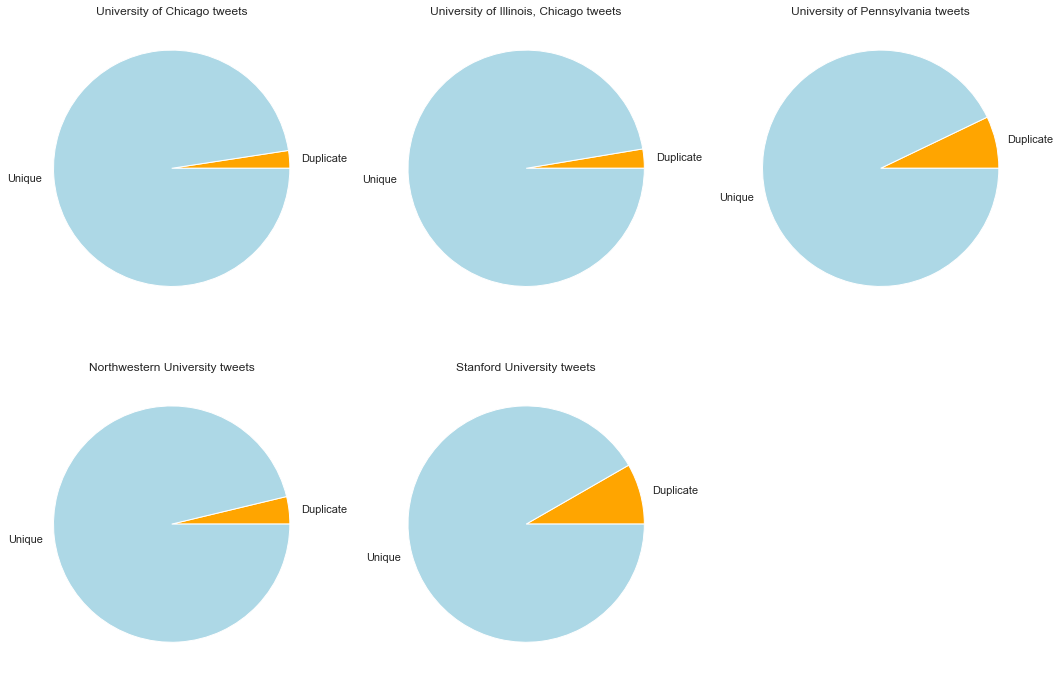

In [86]:
def plot_pie(values, labels, colors, ax):
    ax.pie(x=values, labels=labels, colors=colors)

labels = ['Duplicate', 'Unique']
colors = ['orange','lightblue']
f, ax = plt.subplots(2, 3, figsize=(18, 12))
plot_pie(values=[uc_dup, uc_unique], labels=labels, colors=colors, ax=ax[0][0])
ax[0][0].set(title="University of Chicago tweets")

plot_pie(values=[uic_dup, uic_unique], labels=labels, colors=colors, ax=ax[0][1])
ax[0][1].set(title="University of Illinois, Chicago tweets")

plot_pie(values=[upenn_dup, upenn_unique], labels=labels, colors=colors, ax=ax[0][2])
ax[0][2].set(title="University of Pennsylvania tweets")

plot_pie(values=[nw_dup, nw_unique], labels=labels, colors=colors, ax=ax[1][0])
ax[1][0].set(title="Northwestern University tweets")

plot_pie(values=[stanford_dup, stanford_unique], labels=labels, colors=colors, ax=ax[1][1])
ax[1][1].set(title="Stanford University tweets")

# plot_pie(values=[mit_dup, mit_unique], labels=labels, colors=colors, ax=ax[1][2])
# t = ax[1][2].set(title="MIT tweets")
ax[1][2].set_visible(False)


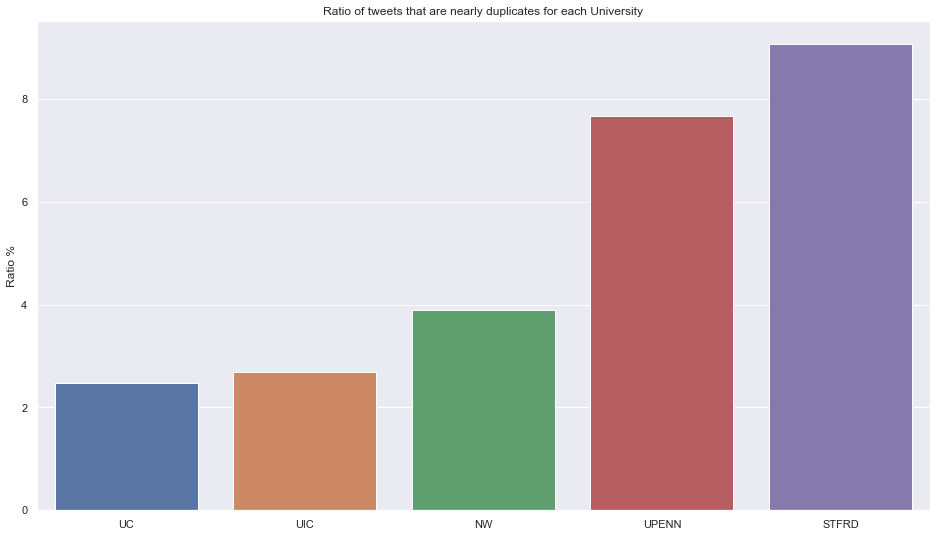

In [91]:
dup_arr = [uc_dup, uic_dup, nw_dup, upenn_dup, stanford_dup]
ori_arr = [uc_unique, uic_unique, nw_unique, upenn_unique, stanford_unique]
ratio_arr = 100*np.asarray(dup_arr) / np.asarray(ori_arr)
uni_arr = ["UC", "UIC", "NW", "UPENN", "STFRD"]
f, ax = plt.subplots(1,1,figsize=(16,9))
g = sns.barplot(y=ratio_arr, x=uni_arr, ax=ax)
t = g.set(title="Ratio of tweets that are nearly duplicates for each University", ylabel="Ratio %")

---------